# Final Lab

# Generative Adversarial Networks(GAN) in PyTorch

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHwq72%2FbtqAY6E0wYb%2FBFRgtJWTY3Ij9BKks7vsM1%2Fimg.png)

# Objective:
The objective of this lab is to introduce students to Generative Adversarial Networks (GANs) and how they can be used to generate synthetic data similar to the MNIST dataset. Students will gain hands-on experience implementing a GAN architecture, training it on a simplified version of the MNIST dataset, and generating new digit images.

# Overview:
Generative Adversarial Networks (GANs) are a class of neural networks used in unsupervised machine learning, particularly in generating synthetic data that resembles real data distributions. In this lab, students will delve into the mechanics of GANs and learn how they consist of two neural networks - a generator and a discriminator - that compete against each other to create realistic synthetic data.

# Tasks:

## 1) Please answer each of the question asked in this notebook.

## 2) Train the Generative Adversarial Network completely and visualize the outputs of your Generator in your notebook.

## 3) Apply GANs on Large-scale Celeb Faces Attributes (CelebA) dataset https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
> To avoid large training times required for GANs without GPU, restrict your training to just 2 or 3 epochs for CelebA dataset.

# Its an individual lab.

## MAIN Reference
1. [PyTorch-GAN | Github/eriklindernoren | Collection of PyTorch implementations of GAN](https://github.com/sw-song/PyTorch-GAN)


## Index
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss Function
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Configure Data Loader
Step 9. Define Optimizers
Step 10. Training
```
---

### Step 1. Import Libraries

In [ ]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

### Step 2. Initial setting

In [ ]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

# Question 1: What does the latent_dim variable used for in the cell below?

The purpose of the latent vector is to represent the random noise or encoded features that the Generator uses to produce diverse images. By sampling different vectors from this space, the Generator can create a wide variety of images while maintaining the learned structure of the dataset.

If latent_dim = 100, each input vector z will have 100 random values.
The Generator learns to map these 100-dimensional vectors to realistic images of shape (channels, img_size, img_size) (e.g., 1 × 28 × 28 for MNIST).

In [ ]:
latent_dim = 100 # suggested default.

In [ ]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

### Step 3. Define Generator

## Question 2: Please explain the architecture of the Generator part of our GAN in the cell below. Is the Generator convolutional or fully-connected?

The Generator is fully connected in this architecture. It uses a series of fully connected (nn.Linear) layers to transform a latent vector (a random input vector, z) into a flattened image representation. Each layer includes an optional normalization step (nn.BatchNorm1d) and an activation function (nn.LeakyReLU) to introduce non-linearity and stabilize training.


The final layer reshapes the output into the desired image shape (img_shape), which is defined as (channels, height, width) for the target image (e.g., 1 × 28 × 28 for MNIST). The nn.Tanh() activation function in the last layer scales the pixel values to the range [-1, 1], which is important for stabilizing GAN training and matching the normalized image data.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

> Read More
- [What is the difference between nn.ReLU() and nn.ReLU(inplace=True)?](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948)
- [Tanh](https://wiki.documentfoundation.org/Documentation/Calc_Functions/TANH)
- [Unpacking Operators in Python](https://towardsdatascience.com/unpacking-operators-in-python-306ae44cd480)

### Step 4. Define Discriminator

## Question 3: Please explain the architecture of the Discrinimator part of our GAN in the cell below. Is the discriminator convolutional or fully-connected?

The Discriminator is also fully connected. It uses a sequence of nn.Linear layers to transform the input image into a single scalar value (validity), which represents the probability of the image being real or fake.


The input image is first flattened into a 1D vector using img.view(img.size(0), -1). Each fully connected layer is followed by a non-linearity (nn.LeakyReLU) to capture complex features. The final layer applies the nn.Sigmoid() activation function, which outputs a value between 0 and 1. This value is interpreted as the Discriminator's confidence that the image is real (1) or fake (0).

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

> Read More
- [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function)
- [pytorch in x = x.view (x.size (0), -1) understanding](https://www.programmersought.com/article/11412923760/)

### Step 5. Define Loss Function

# Question 4: Why is the adversarial loss binary cross-entropy used here?

Binary cross-entropy (BCE) is used as the adversarial loss function because the task is a binary classification problem where the Discriminator predicts whether an image is real or fake. The BCE loss is well-suited for this purpose, as it measures the difference between the predicted probabilities (from the nn.Sigmoid() output) and the actual labels (1 for real images, 0 for fake images).


**For the Discriminator:**

The goal is to maximize the probability of correctly classifying real images as real and fake images as fake.

**For the Generator:**

The Generator tries to minimize the Discriminator's ability to distinguish between real and fake images by generating realistic images. In this way, the Generator's loss is derived from the Discriminator's predictions.

In [ ]:
adversarial_loss = torch.nn.BCELoss()

> Read More
- [BCELoss(Binary Cross Entropy Loss)](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

### Step 6. Initialize generator and Discriminator

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Step 7. GPU Setting

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

### Step 8. Configure Data Loader

Since we use the Kaggle dataset, it is necessary to read the csv file and convert it into an image format.


For the code to load and convert Kaggle MNIST data, I referred to [Pytorch Dataset and DataLoader](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader).


In [ ]:
import pandas as pd
from torch.utils.data import Dataset

In [ ]:
class DatasetMNIST(Dataset): # inherit abstract class - 'Dataset'

    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image ad ndarray type (H, W, C)
        # be carefull for converting dtype to np.uint8 (Unsigned integer (0 to 255))
        # in this example, We use ToTensor(), so we define the numpy array like (H, W, C)

        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)

        return image, label


> TEST CODE : Read CSV file

In [ ]:
!gdown https://drive.google.com/file/d/1yasQ9chYaHy0eiEfwjfy-HQnt-zjhmyw/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1yasQ9chYaHy0eiEfwjfy-HQnt-zjhmyw
To: /content/mnist.csv
100% 76.8M/76.8M [00:00<00:00, 159MB/s]


In [ ]:
train = pd.read_csv('/content/mnist.csv')

In [ ]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> TEST CODE : Construct image from csv file

In [ ]:
for index in range(1, 6): # N : 5 (Number of Image)
    temp_image = train.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
    temp_label = train.iloc[index, 0]
    print('Shape of Image : ',temp_image.shape)
    print('label : ', temp_label)

Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  1
Shape of Image :  (28, 28, 1)
label :  4
Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  0


> TEST CODE : transform from table data to image data with basic preprocessing

In [ ]:
dataset = DatasetMNIST(file_path='/content/mnist.csv',
                       transform=transforms.Compose(
                           [#transforms.Resize(img_size), # Resize is only for PIL Image. Not for numpy array
                            transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])]
                       ))

In [ ]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [ ]:
temp_img.size() # before ToTensor() : (28,28,1), after : (1,28,28)

torch.Size([1, 28, 28])

In [ ]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

> TEST CODE : Define dataloader that can load image by batch

In [ ]:
batch_size = 64 # suggested default, size of the batches
dataloader = DataLoader( # torch.utils.data.DataLoader
    dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
temp_images, _ = next(iter(dataloader))# We don't use label, so _
print('images shape on batch size = {}'.format(temp_images.size()))

images shape on batch size = torch.Size([64, 1, 28, 28])


> Read More
1. [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
    - .ToTensor | Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
    - .ToTensor | Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

### Step 9. Define optimizers

In [ ]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

### Step 10. Training

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpMdme%2FbtqA1ArBCOy%2FqqGg7IvV0hpqVkvBuEFpJK%2Fimg.png)

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# Visualize result
import matplotlib.pyplot as plt

# Question 5: Answer the following questions in the cell below:
### (i) What are the "valid" and "fake" variables initialized for?
Answer:

**"valid":** This variable is initialized to represent labels for real images, typically filled with ones. It is used as a target label when training the discriminator to correctly classify real images.

**"fake":** This variable is initialized to represent labels for fake images, typically filled with zeros. It is used as a target label when training the discriminator to correctly classify generated (fake) images.
### (ii) What does "real_imgs = imgs.type(Tensor)" do and why are we doing it?
Answer:

**What it does:** The line converts the imgs (which may be in a different data type such as torch.float64 or numpy.ndarray) into the specified Tensor type (e.g., torch.FloatTensor).

**Why we do it:** It ensures that the image data is compatible with the operations and model (e.g., the discriminator and generator), which typically require a specific data type like torch.FloatTensor for calculations.
### (iii) What is the tensor z used for in the line: z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
Answer:
**Purpose:** z is the input noise vector for the Generator.

**Explanation:**

np.random.normal(0, 1, ...) generates a batch of random samples from a normal distribution (mean = 0, standard deviation = 1).
The shape (imgs.shape[0], latent_dim) ensures that the batch size matches the number of real images in the input, and the latent_dim is the size of the Generator’s input noise vector.
Tensor(...) converts the numpy array to a PyTorch Tensor for compatibility with the Generator.

### (iv) In the code below, is the Generator updated first or the discriminator?
Answer:

The Discriminator is updated first, followed by the Generator. This is because the Discriminator needs to evaluate both real and fake images before the Generator adjusts its weights based on the Discriminator’s feedback.

### (v) For discriminator you can see it is a sum of two losses "real_loss" and "fake_loss". What do these two losses signify?

**real_loss:** This measures the Discriminator’s ability to correctly classify real images (from the dataset) as real. It compares the Discriminator's output on real images with the "valid" labels (usually ones).


**fake_loss:** This measures the Discriminator’s ability to correctly classify fake images (produced by the Generator) as fake. It compares the Discriminator's output on generated images with the "fake" labels (usually zeros).

  0%|          | 0/657 [00:00<?, ?it/s]

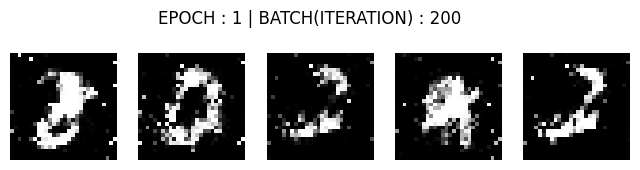

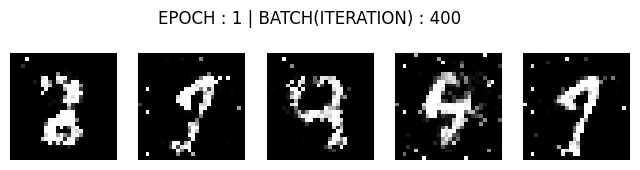

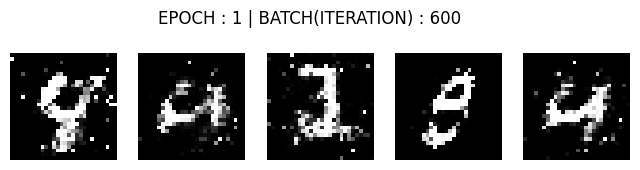

[Epoch: 1/50] [Batch: 657/657] [D loss: 0.415459] [G loss: 1.213058]


  0%|          | 0/657 [00:00<?, ?it/s]

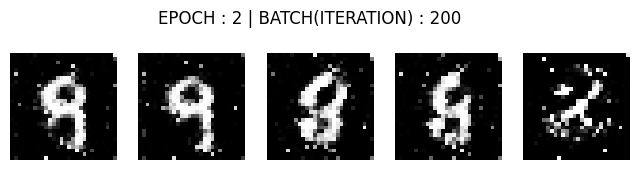

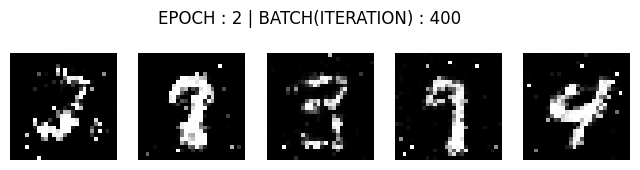

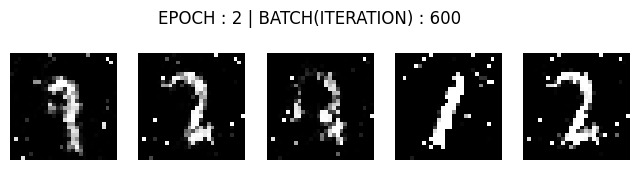

[Epoch: 2/50] [Batch: 657/657] [D loss: 0.472074] [G loss: 1.484638]


  0%|          | 0/657 [00:00<?, ?it/s]

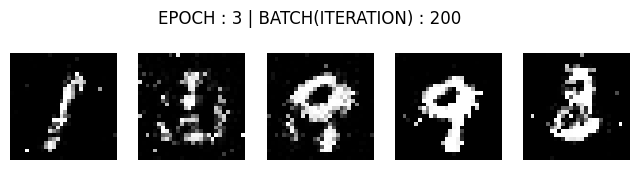

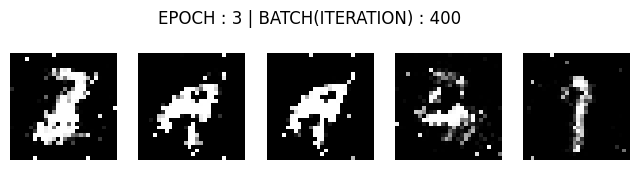

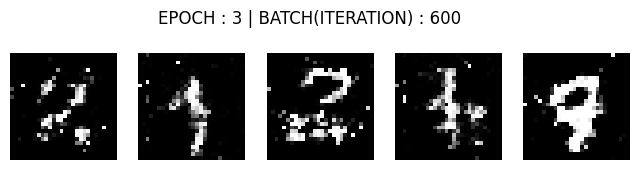

[Epoch: 3/50] [Batch: 657/657] [D loss: 0.364935] [G loss: 2.913861]


  0%|          | 0/657 [00:00<?, ?it/s]

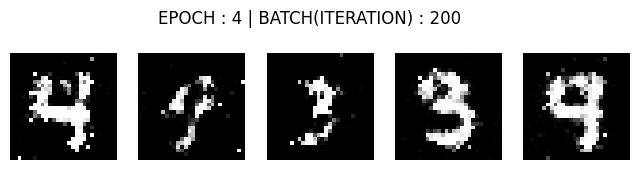

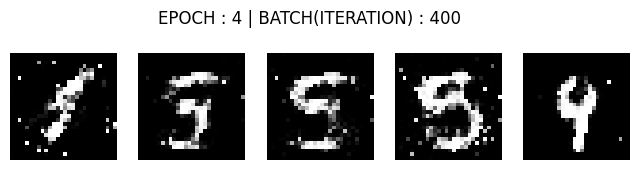

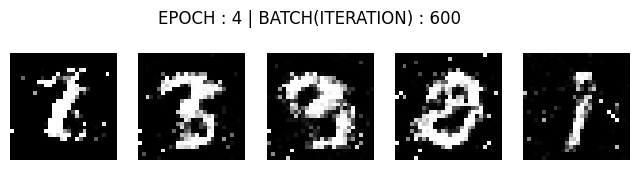

[Epoch: 4/50] [Batch: 657/657] [D loss: 0.401658] [G loss: 3.242113]


  0%|          | 0/657 [00:00<?, ?it/s]

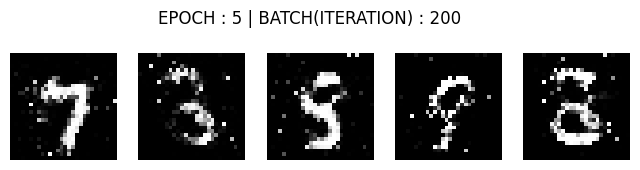

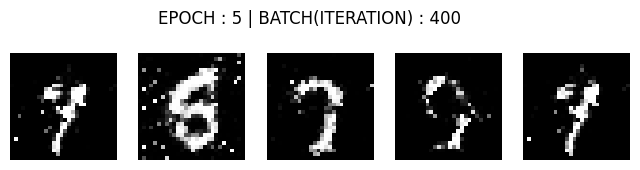

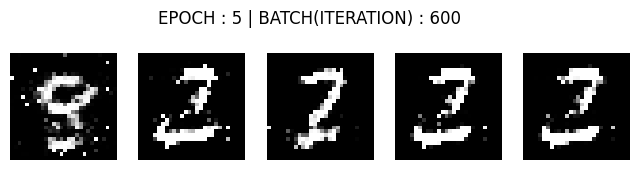

[Epoch: 5/50] [Batch: 657/657] [D loss: 0.194899] [G loss: 1.562760]


  0%|          | 0/657 [00:00<?, ?it/s]

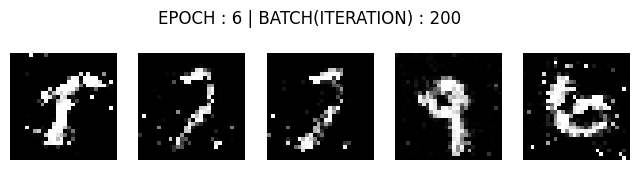

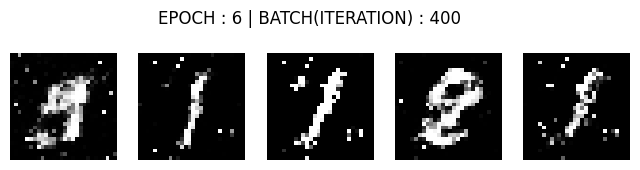

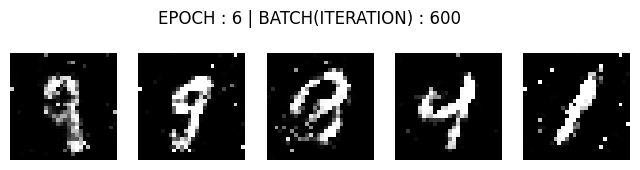

[Epoch: 6/50] [Batch: 657/657] [D loss: 0.325768] [G loss: 1.565373]


  0%|          | 0/657 [00:00<?, ?it/s]

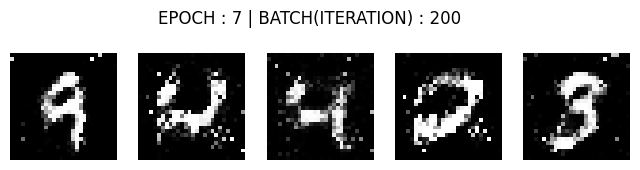

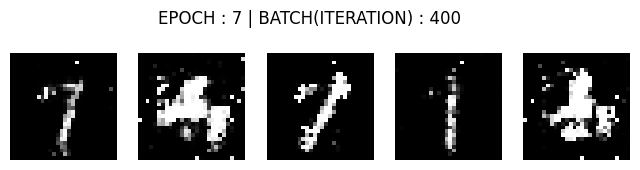

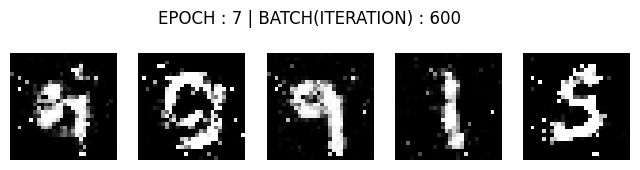

[Epoch: 7/50] [Batch: 657/657] [D loss: 0.295999] [G loss: 1.641527]


  0%|          | 0/657 [00:00<?, ?it/s]

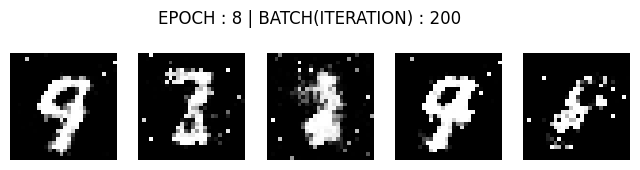

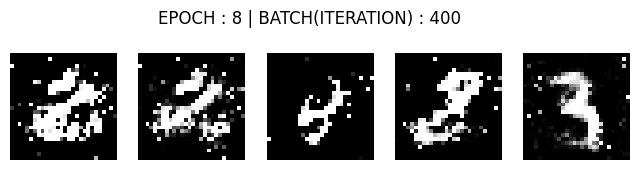

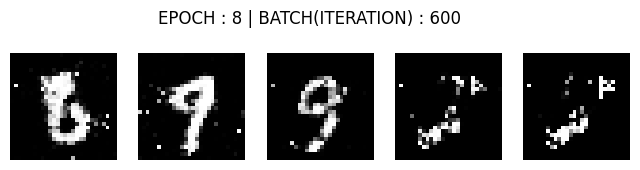

[Epoch: 8/50] [Batch: 657/657] [D loss: 0.517080] [G loss: 0.609789]


  0%|          | 0/657 [00:00<?, ?it/s]

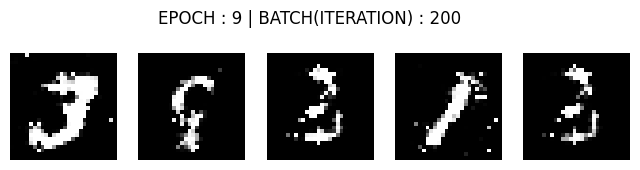

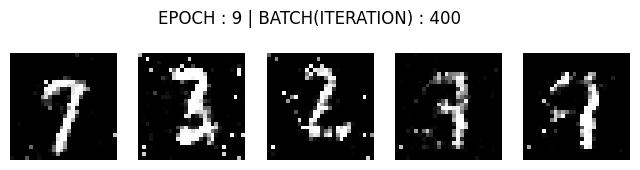

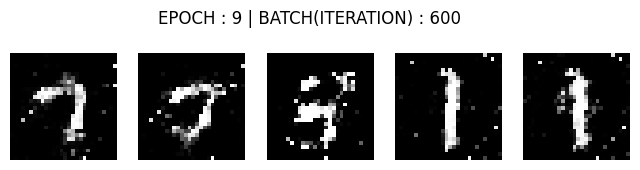

[Epoch: 9/50] [Batch: 657/657] [D loss: 0.391029] [G loss: 1.590230]


  0%|          | 0/657 [00:00<?, ?it/s]

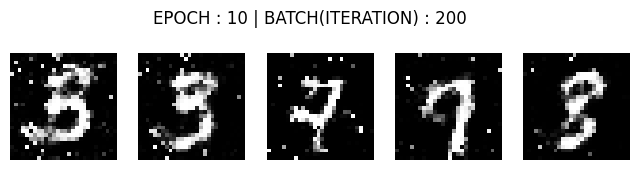

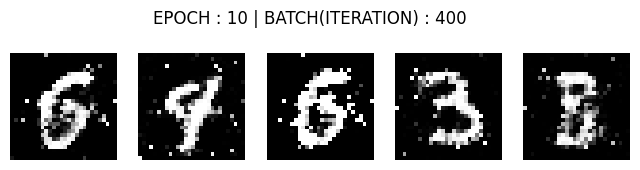

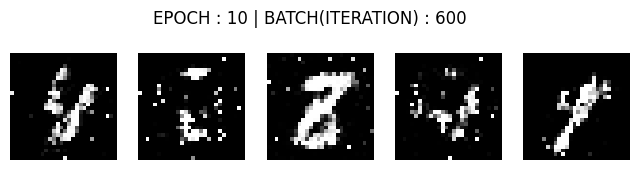

[Epoch: 10/50] [Batch: 657/657] [D loss: 0.308677] [G loss: 2.335470]


  0%|          | 0/657 [00:00<?, ?it/s]

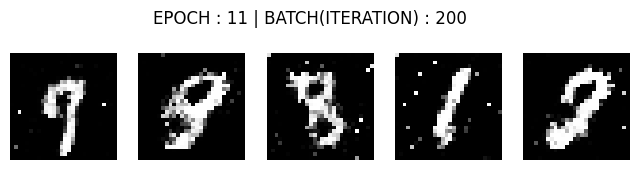

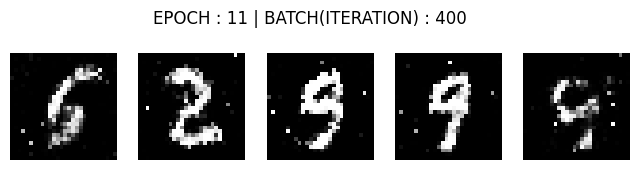

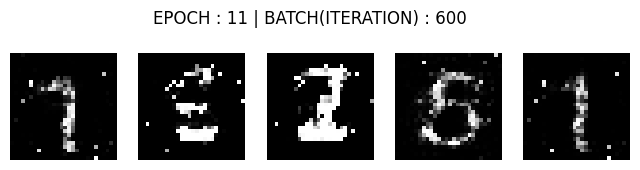

[Epoch: 11/50] [Batch: 657/657] [D loss: 0.228039] [G loss: 2.581117]


  0%|          | 0/657 [00:00<?, ?it/s]

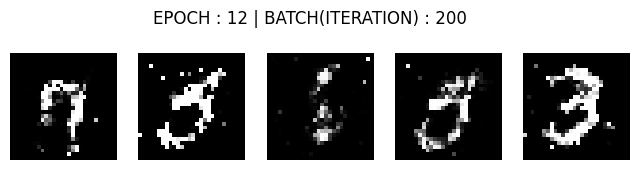

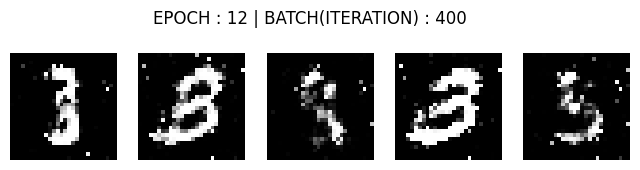

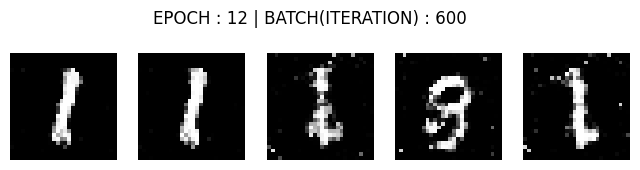

[Epoch: 12/50] [Batch: 657/657] [D loss: 0.269060] [G loss: 2.446748]


  0%|          | 0/657 [00:00<?, ?it/s]

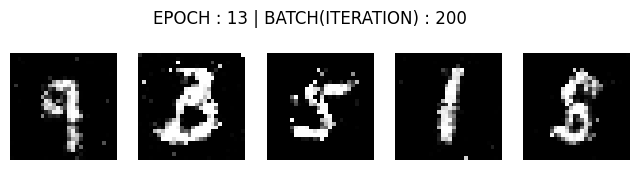

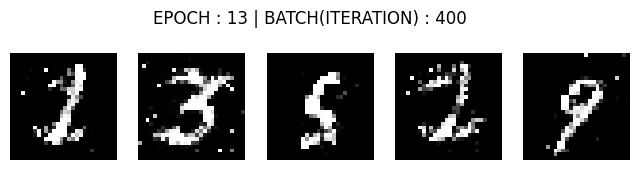

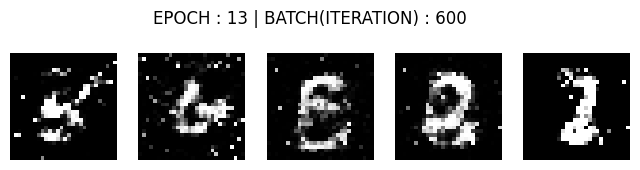

[Epoch: 13/50] [Batch: 657/657] [D loss: 0.411751] [G loss: 4.028235]


  0%|          | 0/657 [00:00<?, ?it/s]

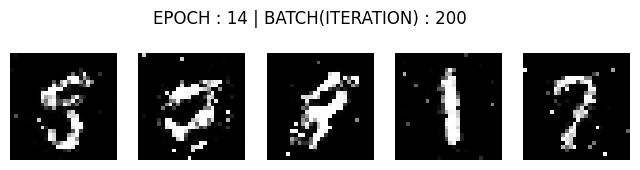

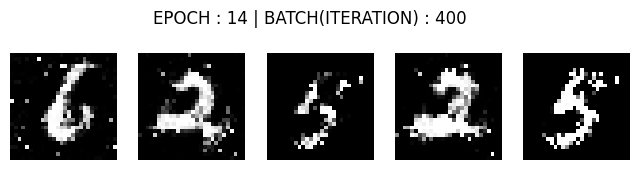

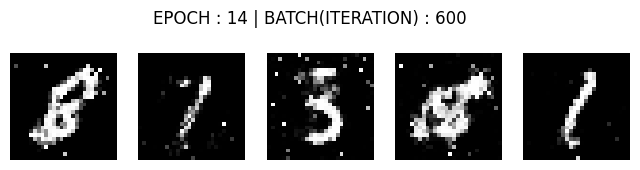

[Epoch: 14/50] [Batch: 657/657] [D loss: 0.458784] [G loss: 0.969926]


  0%|          | 0/657 [00:00<?, ?it/s]

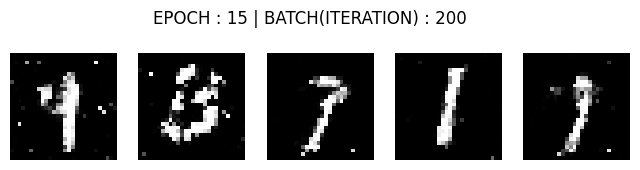

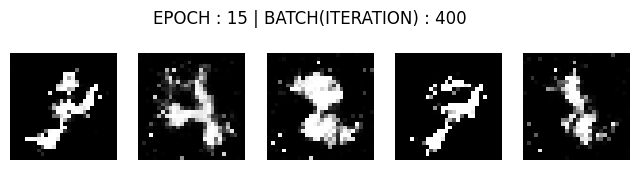

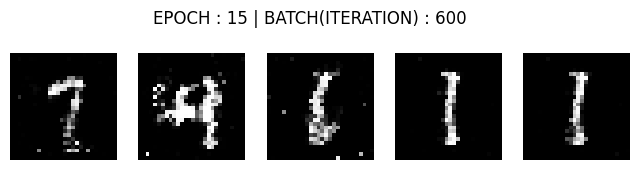

[Epoch: 15/50] [Batch: 657/657] [D loss: 0.353784] [G loss: 1.866996]


  0%|          | 0/657 [00:00<?, ?it/s]

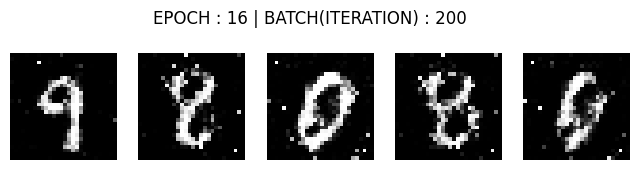

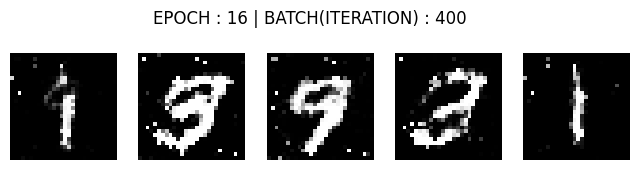

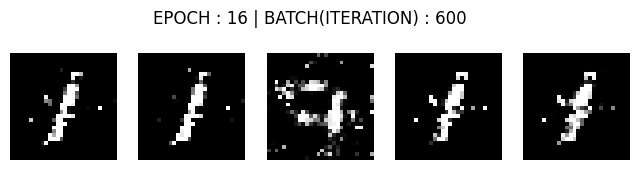

[Epoch: 16/50] [Batch: 657/657] [D loss: 0.239776] [G loss: 2.158051]


  0%|          | 0/657 [00:00<?, ?it/s]

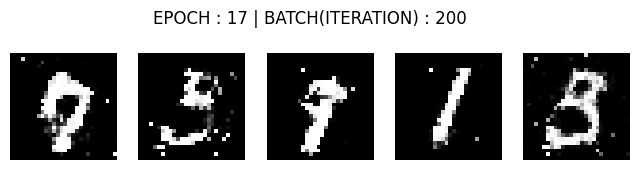

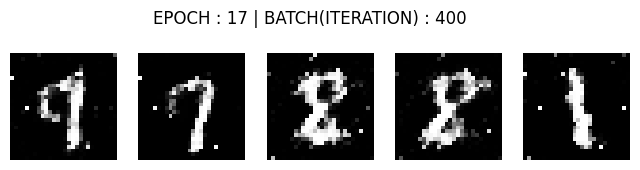

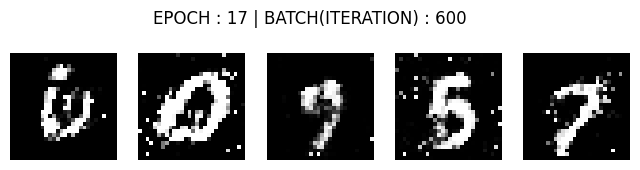

[Epoch: 17/50] [Batch: 657/657] [D loss: 0.239402] [G loss: 2.155422]


  0%|          | 0/657 [00:00<?, ?it/s]

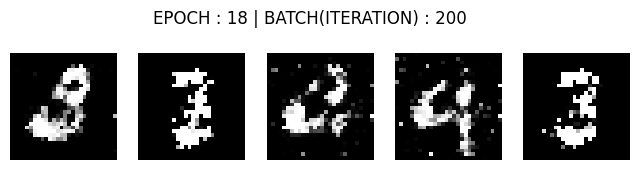

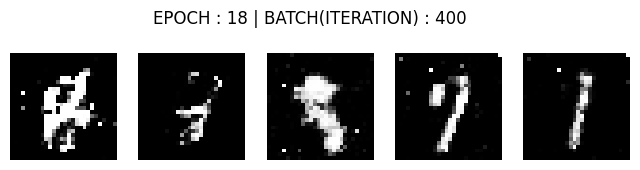

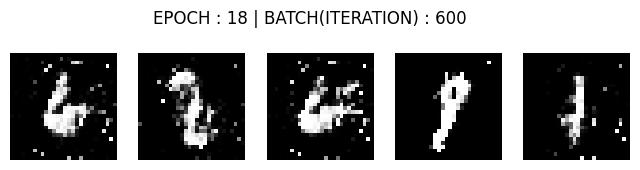

[Epoch: 18/50] [Batch: 657/657] [D loss: 0.146735] [G loss: 2.048417]


  0%|          | 0/657 [00:00<?, ?it/s]

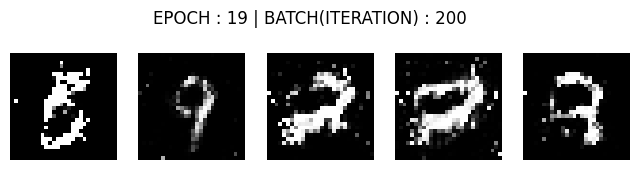

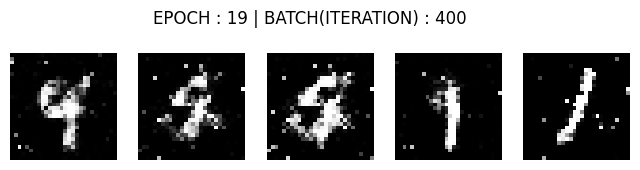

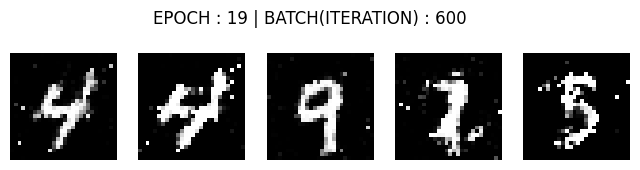

[Epoch: 19/50] [Batch: 657/657] [D loss: 0.181431] [G loss: 2.971613]


  0%|          | 0/657 [00:00<?, ?it/s]

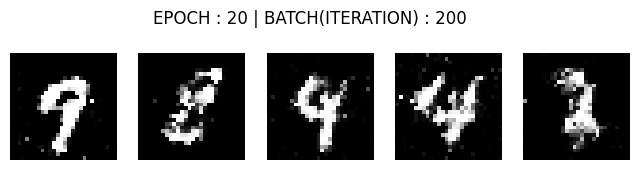

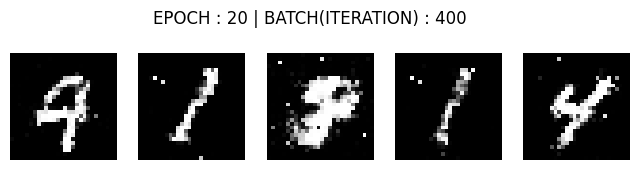

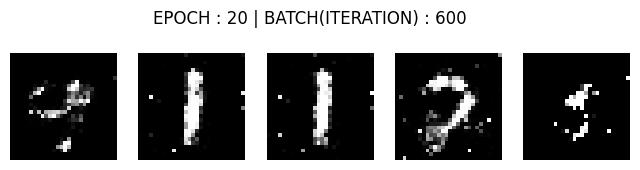

[Epoch: 20/50] [Batch: 657/657] [D loss: 0.210678] [G loss: 2.325257]


  0%|          | 0/657 [00:00<?, ?it/s]

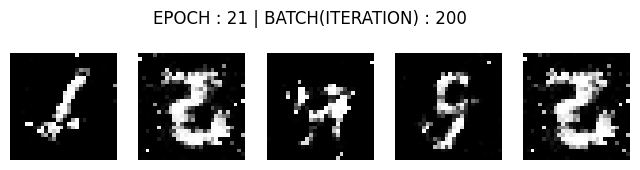

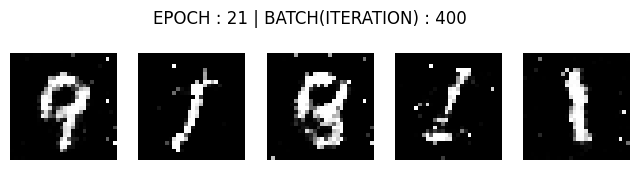

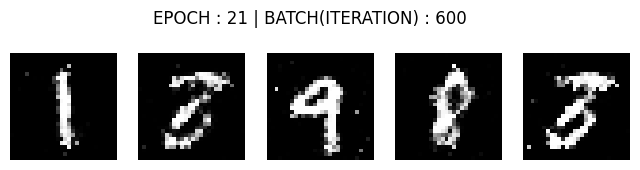

[Epoch: 21/50] [Batch: 657/657] [D loss: 0.255635] [G loss: 2.040140]


  0%|          | 0/657 [00:00<?, ?it/s]

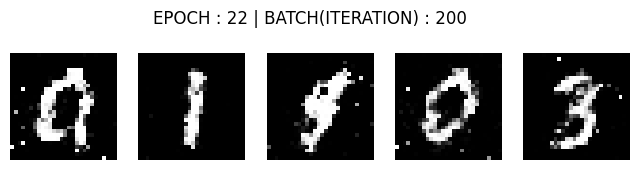

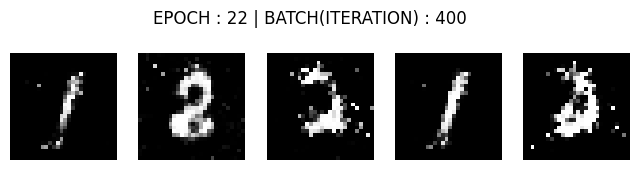

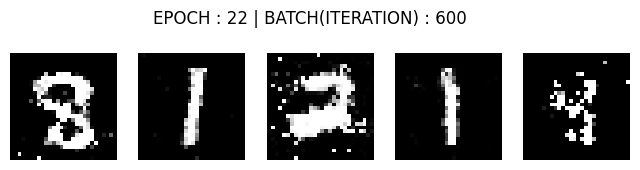

[Epoch: 22/50] [Batch: 657/657] [D loss: 0.246079] [G loss: 2.284799]


  0%|          | 0/657 [00:00<?, ?it/s]

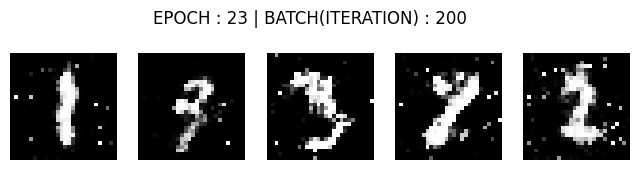

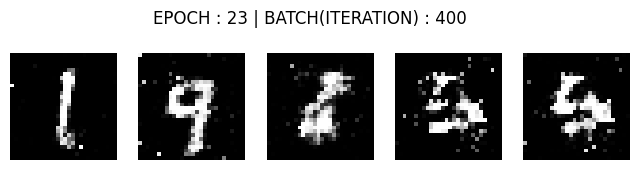

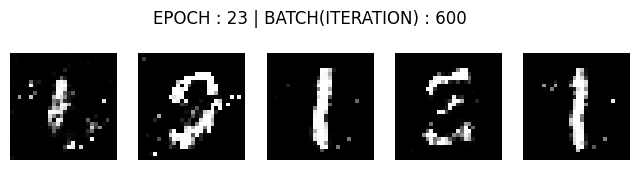

[Epoch: 23/50] [Batch: 657/657] [D loss: 0.191039] [G loss: 2.258866]


  0%|          | 0/657 [00:00<?, ?it/s]

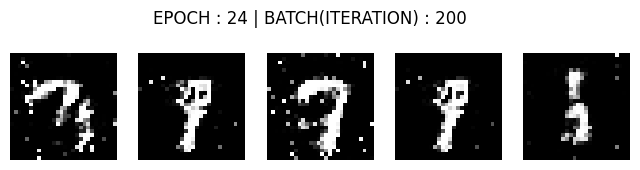

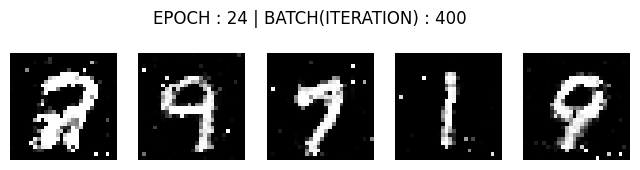

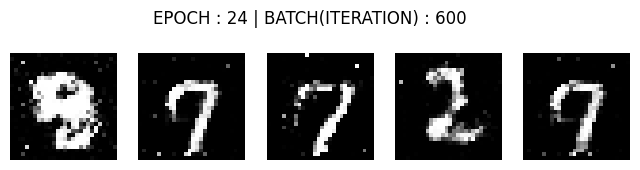

[Epoch: 24/50] [Batch: 657/657] [D loss: 0.453743] [G loss: 2.768856]


  0%|          | 0/657 [00:00<?, ?it/s]

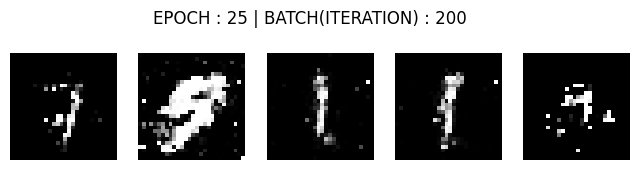

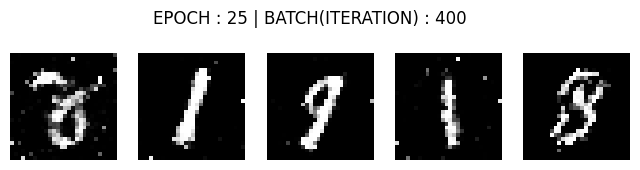

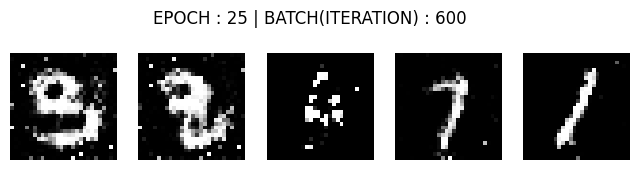

[Epoch: 25/50] [Batch: 657/657] [D loss: 0.255965] [G loss: 1.547144]


  0%|          | 0/657 [00:00<?, ?it/s]

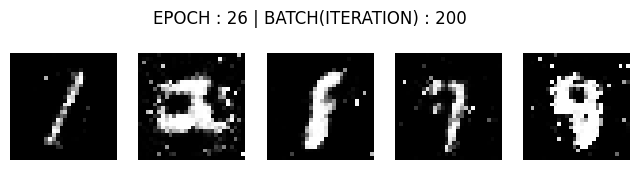

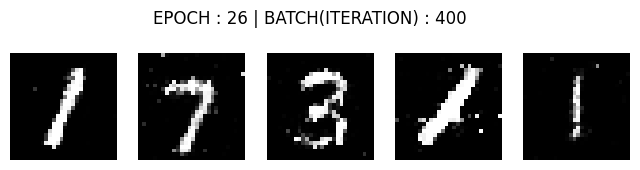

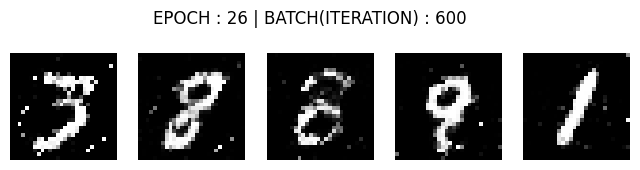

[Epoch: 26/50] [Batch: 657/657] [D loss: 0.169229] [G loss: 1.803107]


  0%|          | 0/657 [00:00<?, ?it/s]

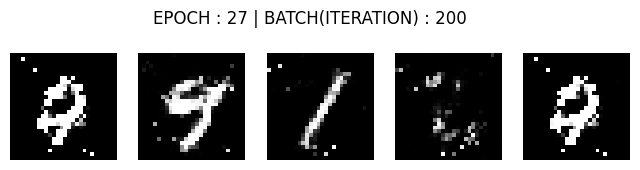

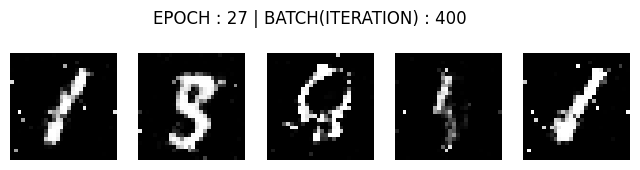

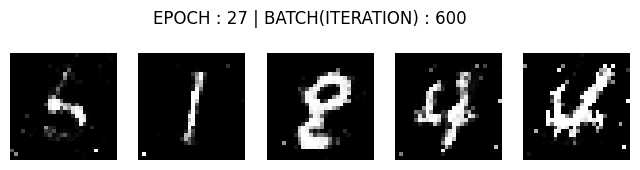

[Epoch: 27/50] [Batch: 657/657] [D loss: 0.228978] [G loss: 1.418662]


  0%|          | 0/657 [00:00<?, ?it/s]

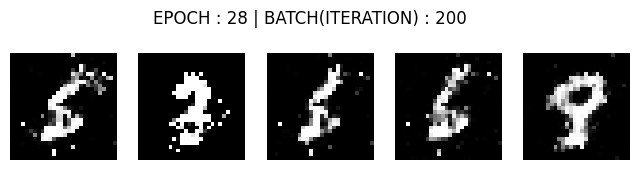

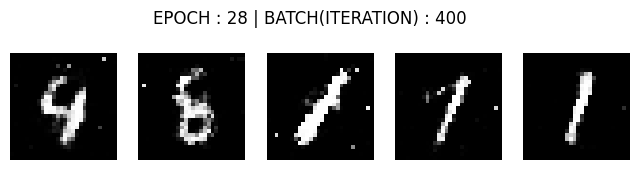

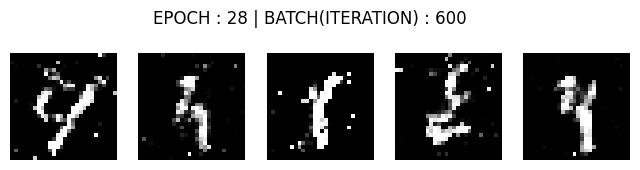

[Epoch: 28/50] [Batch: 657/657] [D loss: 0.217990] [G loss: 2.620391]


  0%|          | 0/657 [00:00<?, ?it/s]

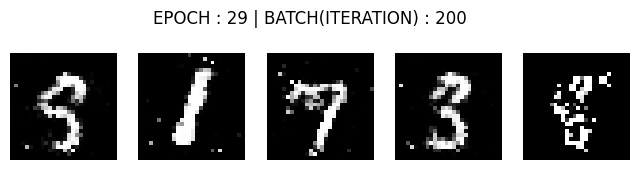

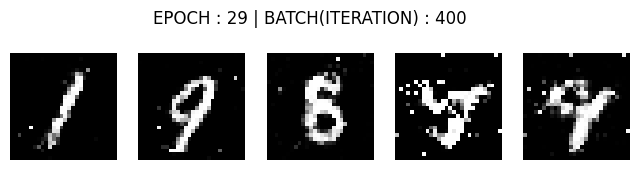

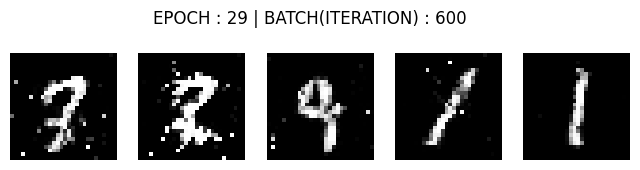

[Epoch: 29/50] [Batch: 657/657] [D loss: 0.243537] [G loss: 2.608035]


  0%|          | 0/657 [00:00<?, ?it/s]

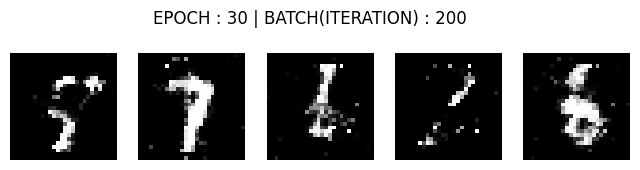

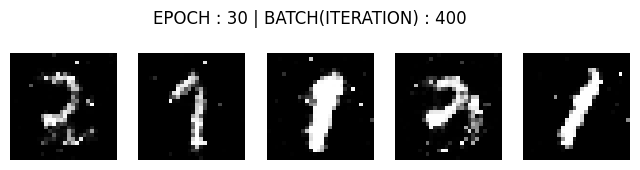

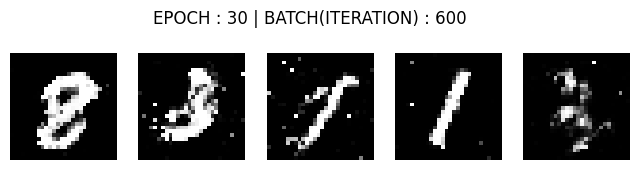

[Epoch: 30/50] [Batch: 657/657] [D loss: 0.256272] [G loss: 1.834417]


  0%|          | 0/657 [00:00<?, ?it/s]

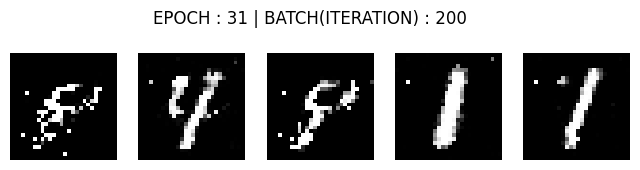

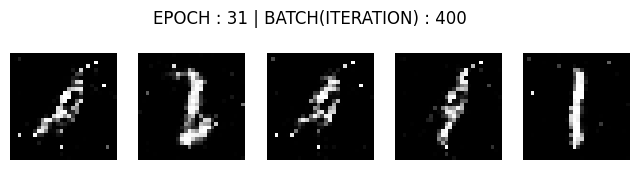

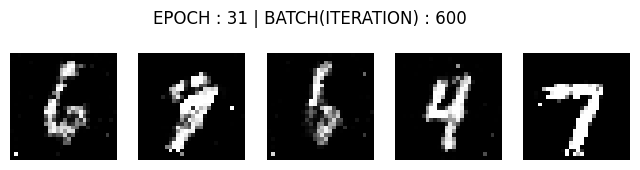

[Epoch: 31/50] [Batch: 657/657] [D loss: 0.311216] [G loss: 1.523929]


  0%|          | 0/657 [00:00<?, ?it/s]

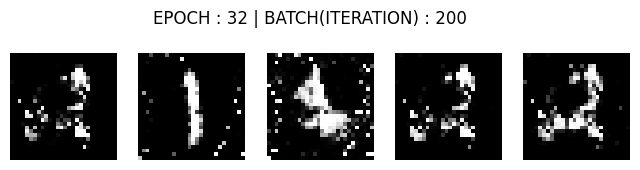

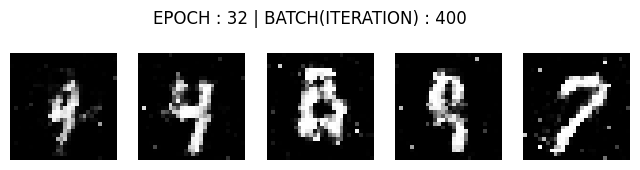

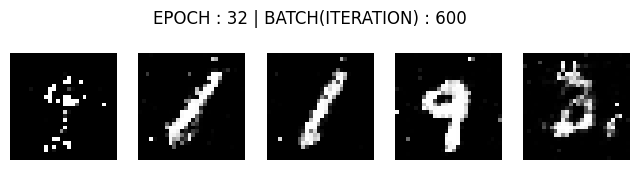

[Epoch: 32/50] [Batch: 657/657] [D loss: 0.402024] [G loss: 2.594105]


  0%|          | 0/657 [00:00<?, ?it/s]

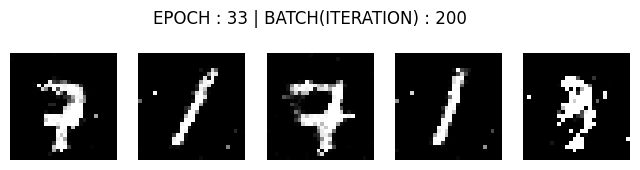

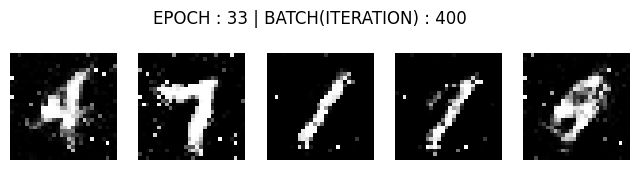

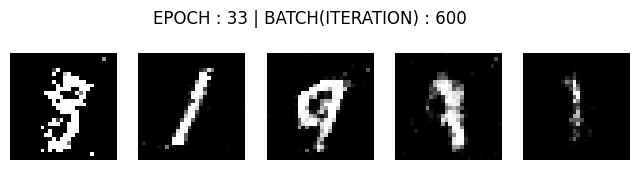

[Epoch: 33/50] [Batch: 657/657] [D loss: 0.386181] [G loss: 5.023113]


  0%|          | 0/657 [00:00<?, ?it/s]

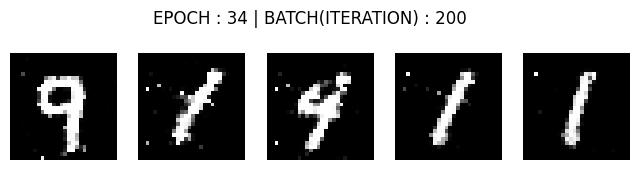

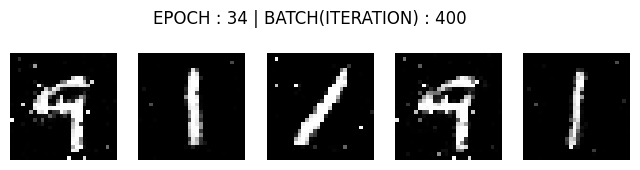

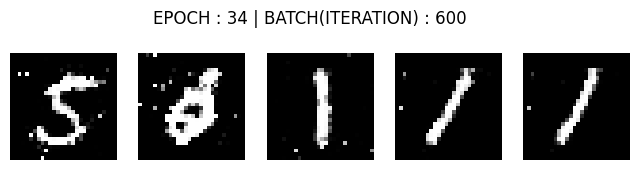

[Epoch: 34/50] [Batch: 657/657] [D loss: 0.579865] [G loss: 5.101622]


  0%|          | 0/657 [00:00<?, ?it/s]

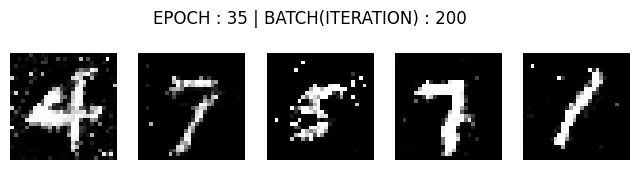

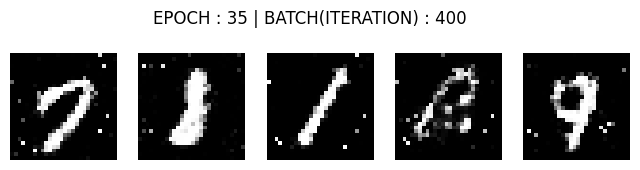

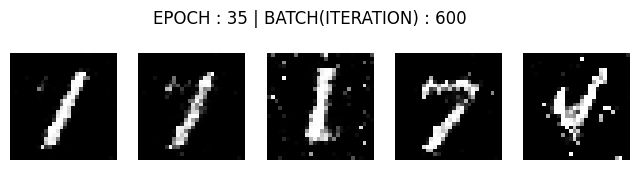

[Epoch: 35/50] [Batch: 657/657] [D loss: 0.267156] [G loss: 2.364705]


  0%|          | 0/657 [00:00<?, ?it/s]

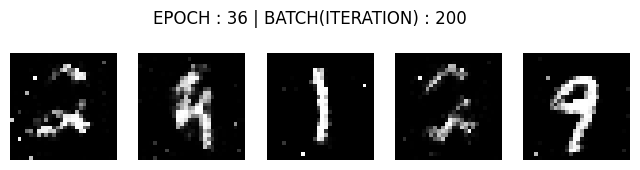

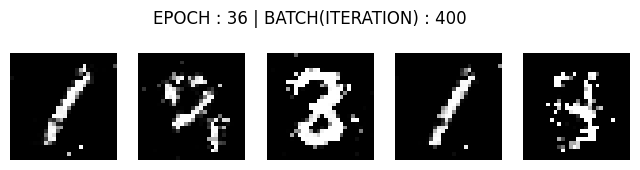

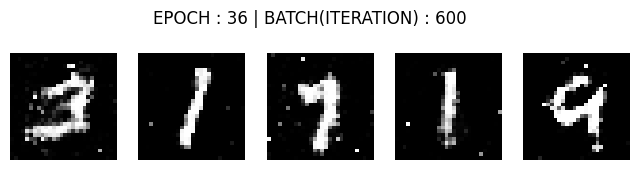

[Epoch: 36/50] [Batch: 657/657] [D loss: 0.165265] [G loss: 1.999438]


  0%|          | 0/657 [00:00<?, ?it/s]

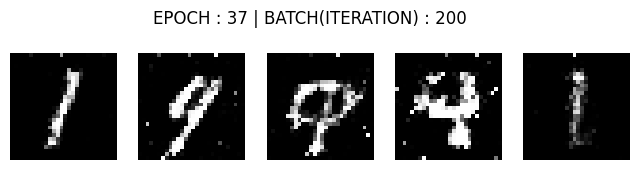

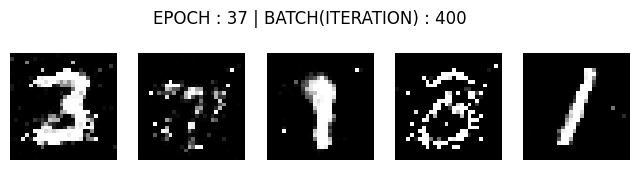

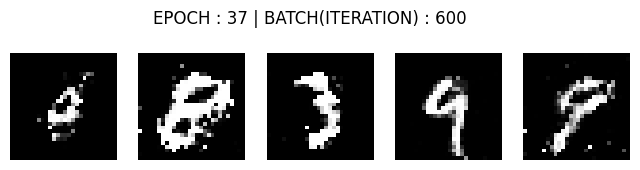

[Epoch: 37/50] [Batch: 657/657] [D loss: 0.195154] [G loss: 2.260855]


  0%|          | 0/657 [00:00<?, ?it/s]

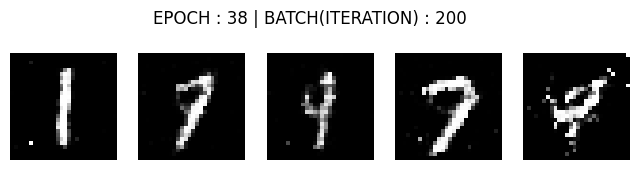

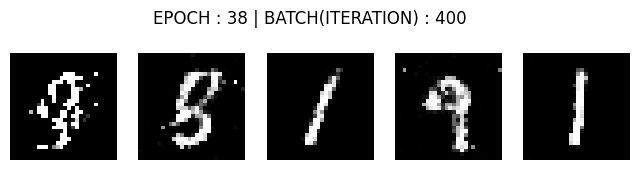

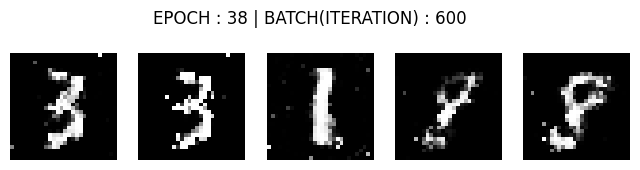

[Epoch: 38/50] [Batch: 657/657] [D loss: 0.380675] [G loss: 3.068034]


  0%|          | 0/657 [00:00<?, ?it/s]

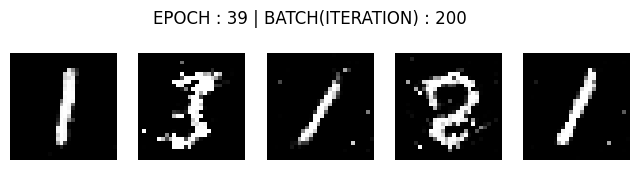

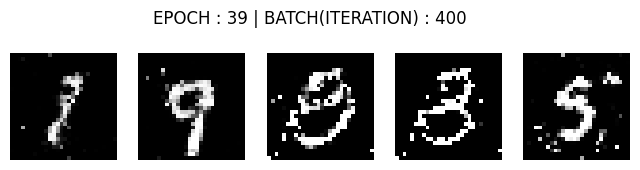

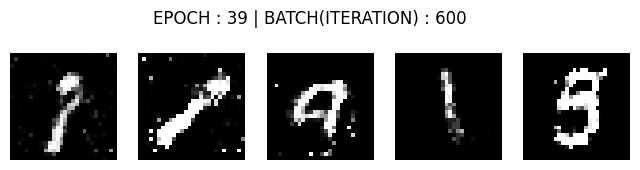

[Epoch: 39/50] [Batch: 657/657] [D loss: 0.148717] [G loss: 2.175726]


  0%|          | 0/657 [00:00<?, ?it/s]

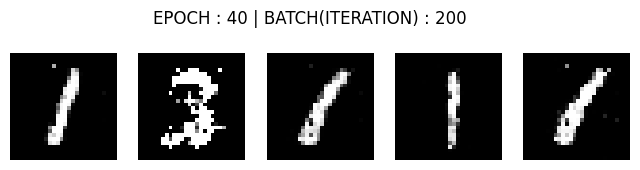

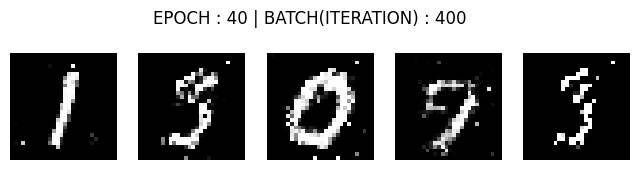

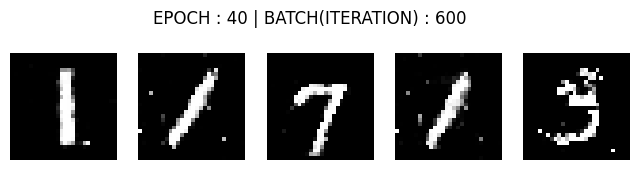

[Epoch: 40/50] [Batch: 657/657] [D loss: 0.278803] [G loss: 2.169015]


  0%|          | 0/657 [00:00<?, ?it/s]

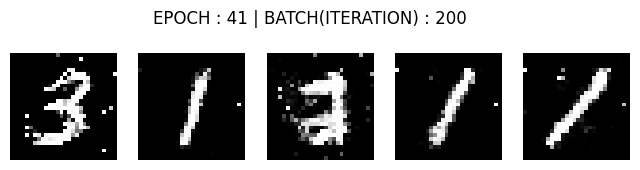

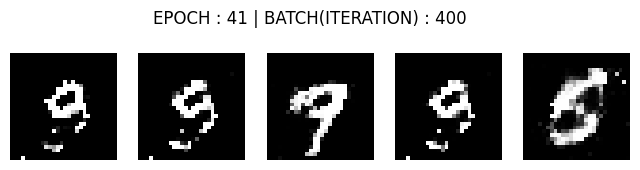

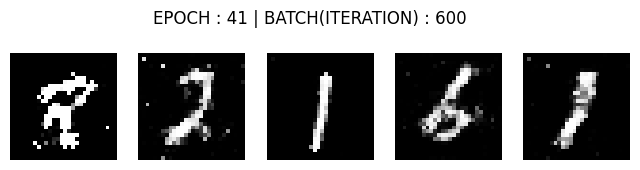

[Epoch: 41/50] [Batch: 657/657] [D loss: 0.247736] [G loss: 1.512142]


  0%|          | 0/657 [00:00<?, ?it/s]

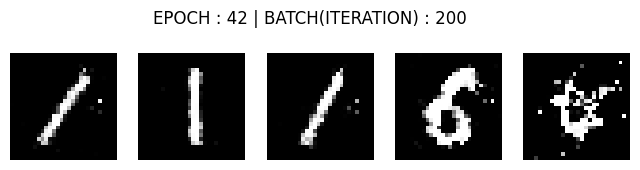

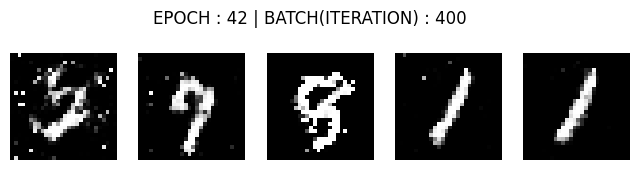

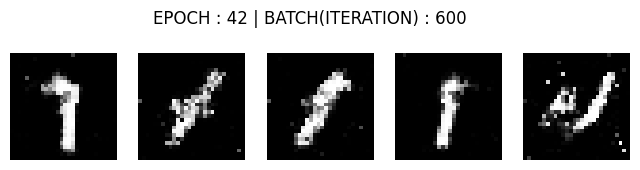

[Epoch: 42/50] [Batch: 657/657] [D loss: 0.299443] [G loss: 1.492631]


  0%|          | 0/657 [00:00<?, ?it/s]

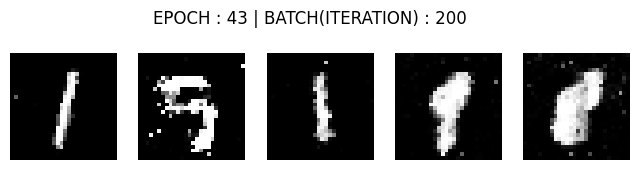

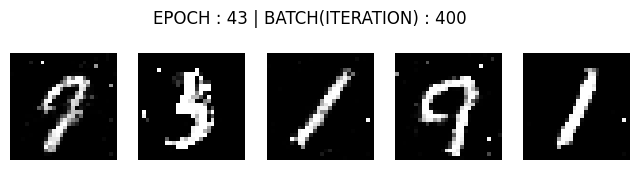

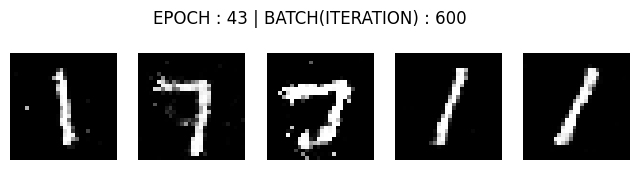

[Epoch: 43/50] [Batch: 657/657] [D loss: 0.378598] [G loss: 2.888394]


  0%|          | 0/657 [00:00<?, ?it/s]

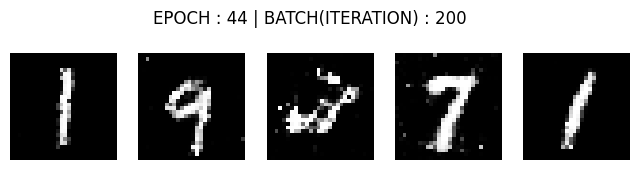

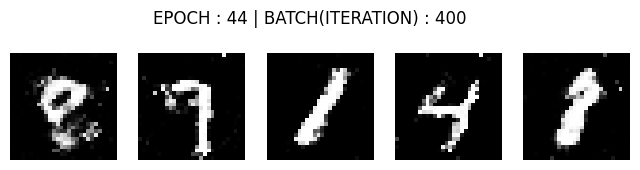

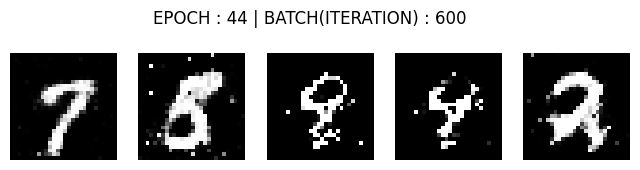

[Epoch: 44/50] [Batch: 657/657] [D loss: 0.202529] [G loss: 1.566965]


  0%|          | 0/657 [00:00<?, ?it/s]

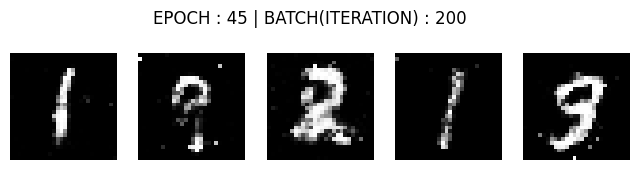

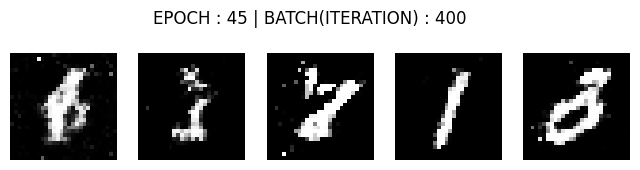

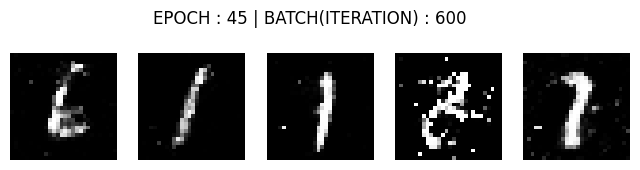

[Epoch: 45/50] [Batch: 657/657] [D loss: 0.237025] [G loss: 1.827568]


  0%|          | 0/657 [00:00<?, ?it/s]

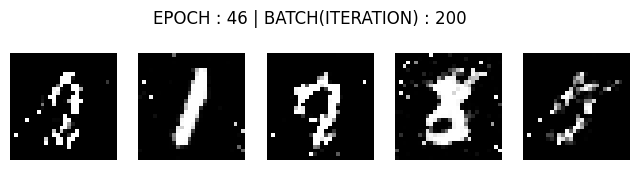

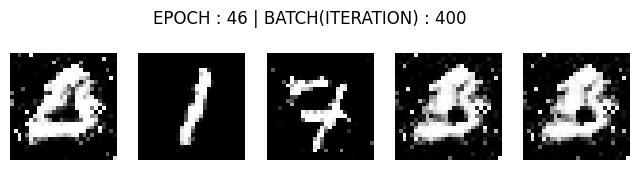

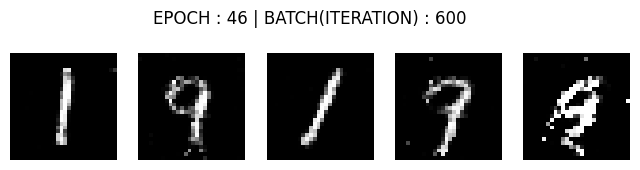

[Epoch: 46/50] [Batch: 657/657] [D loss: 0.247214] [G loss: 2.284716]


  0%|          | 0/657 [00:00<?, ?it/s]

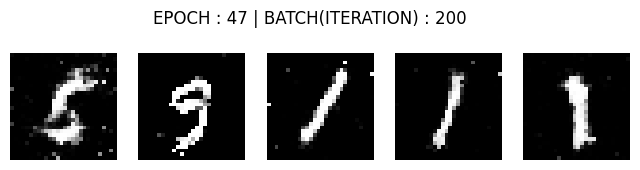

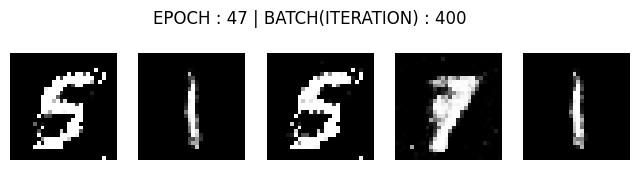

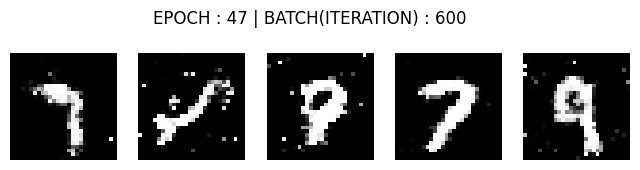

[Epoch: 47/50] [Batch: 657/657] [D loss: 0.225637] [G loss: 1.688428]


  0%|          | 0/657 [00:00<?, ?it/s]

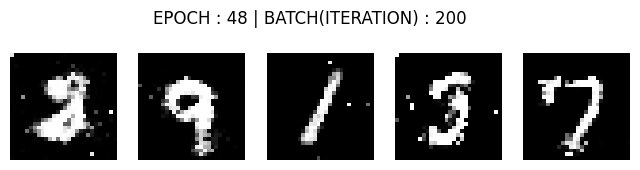

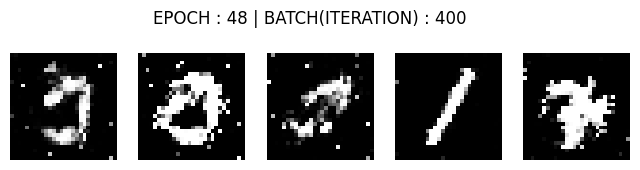

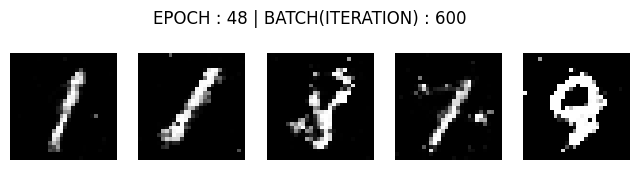

[Epoch: 48/50] [Batch: 657/657] [D loss: 0.164658] [G loss: 3.149148]


  0%|          | 0/657 [00:00<?, ?it/s]

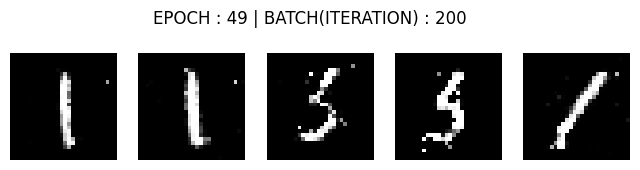

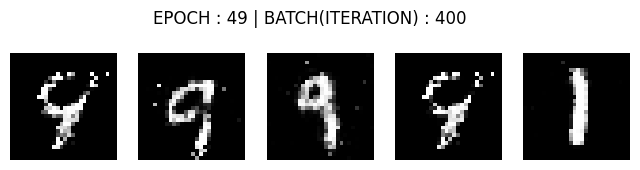

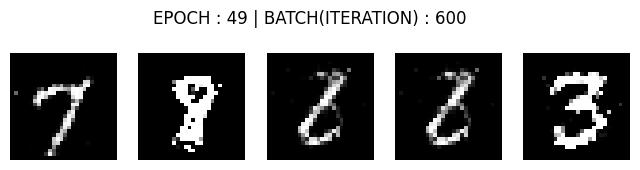

[Epoch: 49/50] [Batch: 657/657] [D loss: 0.122026] [G loss: 2.540705]


  0%|          | 0/657 [00:00<?, ?it/s]

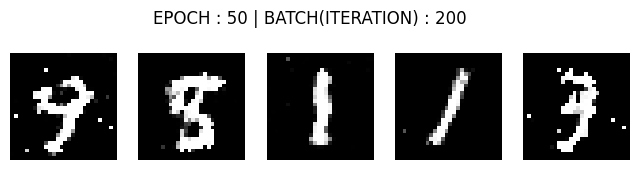

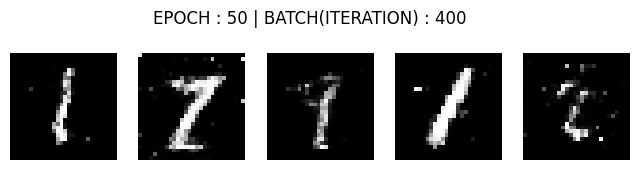

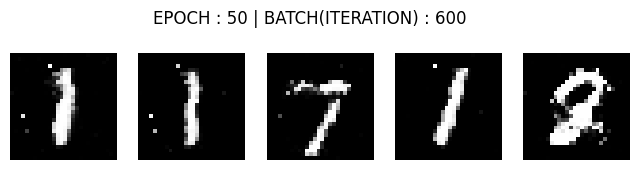

[Epoch: 50/50] [Batch: 657/657] [D loss: 0.265474] [G loss: 3.086404]


In [ ]:
n_epochs = 50 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

> TEST CODE : enumerate >> [docs.python.org/enumerate](https://docs.python.org/3/library/functions.html#enumerate)

# Now to generate our own images. First we sample a random noise vector z that would be fed to the generator.

In [ ]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
sample_z.shape

torch.Size([64, 100])

# We provide the latent vectors (64 in this case) to the Generator

In [ ]:
# generated images
sample_gen_imgs = generator(sample_z)
sample_gen_imgs.shape

torch.Size([64, 1, 28, 28])

# Question 6 How many images did the Generator produce?

The first dimension of the generator indicates the batch size, 64 images in the above case.

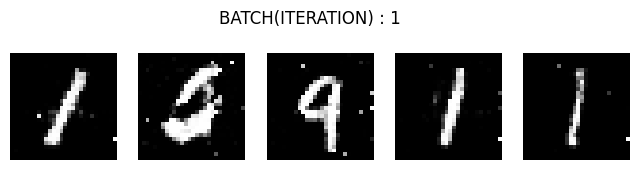

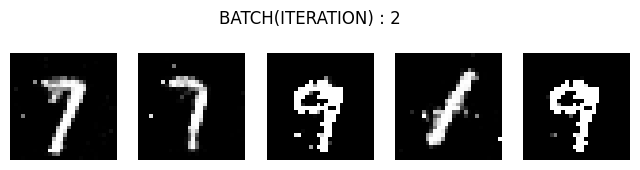

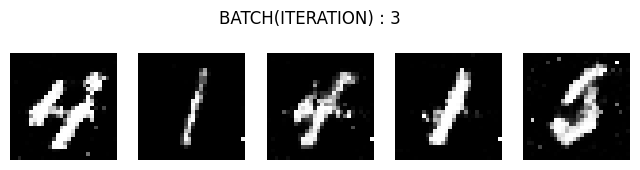

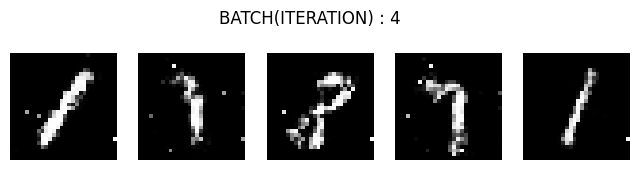

In [ ]:
for i in range(4):
      nrow=1
      ncols=5
      fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
      plt.suptitle('BATCH(ITERATION) : {}'.format(i+1))
      for ncol in range(ncols):
          axes[ncol].imshow(sample_gen_imgs.detach().cpu().permute(0,2,3,1)[ncol+i*5], cmap='gray')
          axes[ncol].axis('off')
      plt.show()

> Read More
- [What is Ground Truth? - Definition from Techpedia](https://www.techopedia.com/definition/32514/ground-truth)
- [tqdm. A Fast, Extensible Progress Bar for Python and CLI](https://github.com/tqdm/tqdm)
- [Variables are no longer necessary to use autograd with tensors](https://pytorch.org/docs/stable/autograd.html#variable-deprecated)
- [np.random.normal(loc=0.0, scale=1.0, size=None)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)



--------------

### You might be wondering how do we control the output of the Generator? Since we are using a vanilla GAN we don't have control over the generator outputs. However, we have other types of GANs like the Conditional GANs or CGANs for short that provide us control over the outputs of our generator. You can explore these types of GANs and train them on MNIST to generate digits of your choice.

### Notebook Credits:
This lab is based on the notebook provided by "sw-song" on Kaggle.

https://www.kaggle.com/code/songseungwon/pytorch-gan-basic-tutorial-for-beginner/notebook

# Applying GANs to CelebA Dataset

### Step 1. Import Libraries

In [1]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

### Step 2. Initial setting

In [2]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [3]:
latent_dim = 100 # suggested default.

In [4]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

### Step 3. Define Generator

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 64 * 64),  # Output size for 64x64 RGB image
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 64, 64)  # Reshape to (batch_size, channels, height, width)
        return img

### Step 4. Define Discriminator

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        validity = self.model(img_flat)
        return validity

### Step 5. Define Loss Function

In [44]:
adversarial_loss = torch.nn.BCELoss()

### Step 6. Initialize generator and Discriminator

In [45]:
generator = Generator()
discriminator = Discriminator()

In [46]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=12288, bias=True)
    (3): Tanh()
  )
)

In [47]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=12288, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

### Step 7. GPU Setting

In [48]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

### Step 8. Configure Data Loader

Since we use the Kaggle dataset, it is necessary to read the csv file and convert it into an image format.


For the code to load and convert Kaggle MNIST data, I referred to [Pytorch Dataset and DataLoader](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader).


In [49]:
import pandas as pd
from torch.utils.data import Dataset

> TEST CODE : Read CSV file

In [50]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


> TEST CODE : transform from table data to image data with basic preprocessing

### Step 9. Define optimizers

In [51]:
# Initialize models
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

### Step 10. Training

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpMdme%2FbtqA1ArBCOy%2FqqGg7IvV0hpqVkvBuEFpJK%2Fimg.png)

In [52]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [53]:
from tqdm.notebook import tqdm

In [54]:
# Visualize result
import matplotlib.pyplot as plt

In [57]:
# Configure data loader
transforms_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root=path, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
pythonCopyn_epochs = 2  # As mentioned in the task, we'll train for just 2-3 epochs
batches_done = 0


In [61]:
for epoch in range(3):
    for i, (imgs, _) in enumerate(tqdm(dataloader)):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
# Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, 3, i, len(dataloader), d_loss.item(), g_loss.item())
            )


  0%|          | 0/3166 [00:00<?, ?it/s]

[Epoch 0/3] [Batch 0/3166] [D loss: 0.454301] [G loss: 4.225155]
[Epoch 0/3] [Batch 100/3166] [D loss: 0.103649] [G loss: 1.769444]
[Epoch 0/3] [Batch 200/3166] [D loss: 0.277462] [G loss: 0.941777]
[Epoch 0/3] [Batch 300/3166] [D loss: 0.698128] [G loss: 0.350203]
[Epoch 0/3] [Batch 400/3166] [D loss: 0.052401] [G loss: 2.786791]
[Epoch 0/3] [Batch 500/3166] [D loss: 0.157134] [G loss: 3.400174]
[Epoch 0/3] [Batch 600/3166] [D loss: 0.274215] [G loss: 4.048584]
[Epoch 0/3] [Batch 700/3166] [D loss: 0.206499] [G loss: 2.871819]
[Epoch 0/3] [Batch 800/3166] [D loss: 0.161273] [G loss: 1.471297]
[Epoch 0/3] [Batch 900/3166] [D loss: 0.082264] [G loss: 2.541583]
[Epoch 0/3] [Batch 1000/3166] [D loss: 0.436939] [G loss: 0.710798]
[Epoch 0/3] [Batch 1100/3166] [D loss: 0.146799] [G loss: 1.815187]
[Epoch 0/3] [Batch 1200/3166] [D loss: 0.225150] [G loss: 1.254264]
[Epoch 0/3] [Batch 1300/3166] [D loss: 0.192929] [G loss: 2.367325]
[Epoch 0/3] [Batch 1400/3166] [D loss: 0.384968] [G loss: 0.

  0%|          | 0/3166 [00:00<?, ?it/s]

[Epoch 1/3] [Batch 0/3166] [D loss: 0.307683] [G loss: 4.783749]
[Epoch 1/3] [Batch 100/3166] [D loss: 0.064732] [G loss: 3.539712]
[Epoch 1/3] [Batch 200/3166] [D loss: 0.227467] [G loss: 1.968508]
[Epoch 1/3] [Batch 300/3166] [D loss: 0.146201] [G loss: 2.543390]
[Epoch 1/3] [Batch 400/3166] [D loss: 0.303710] [G loss: 1.666258]
[Epoch 1/3] [Batch 500/3166] [D loss: 0.145004] [G loss: 2.265843]
[Epoch 1/3] [Batch 600/3166] [D loss: 0.143165] [G loss: 2.872342]
[Epoch 1/3] [Batch 700/3166] [D loss: 0.186717] [G loss: 4.038089]
[Epoch 1/3] [Batch 800/3166] [D loss: 0.185825] [G loss: 2.550640]
[Epoch 1/3] [Batch 900/3166] [D loss: 0.245823] [G loss: 1.856389]
[Epoch 1/3] [Batch 1000/3166] [D loss: 0.160225] [G loss: 3.621049]
[Epoch 1/3] [Batch 1100/3166] [D loss: 0.107726] [G loss: 2.552114]
[Epoch 1/3] [Batch 1200/3166] [D loss: 0.120300] [G loss: 3.368298]
[Epoch 1/3] [Batch 1300/3166] [D loss: 0.323044] [G loss: 1.677551]
[Epoch 1/3] [Batch 1400/3166] [D loss: 0.251036] [G loss: 1.

  0%|          | 0/3166 [00:00<?, ?it/s]

[Epoch 2/3] [Batch 0/3166] [D loss: 0.215785] [G loss: 2.324256]
[Epoch 2/3] [Batch 100/3166] [D loss: 0.161782] [G loss: 2.855249]
[Epoch 2/3] [Batch 200/3166] [D loss: 0.229727] [G loss: 2.251113]
[Epoch 2/3] [Batch 300/3166] [D loss: 0.177638] [G loss: 2.942708]
[Epoch 2/3] [Batch 400/3166] [D loss: 0.642953] [G loss: 1.986106]
[Epoch 2/3] [Batch 500/3166] [D loss: 0.185750] [G loss: 2.262047]
[Epoch 2/3] [Batch 600/3166] [D loss: 0.235855] [G loss: 2.872199]
[Epoch 2/3] [Batch 700/3166] [D loss: 0.254324] [G loss: 3.325738]
[Epoch 2/3] [Batch 800/3166] [D loss: 0.213463] [G loss: 2.384108]
[Epoch 2/3] [Batch 900/3166] [D loss: 0.915033] [G loss: 4.435775]
[Epoch 2/3] [Batch 1000/3166] [D loss: 0.204825] [G loss: 3.061234]
[Epoch 2/3] [Batch 1100/3166] [D loss: 0.447893] [G loss: 5.294404]
[Epoch 2/3] [Batch 1200/3166] [D loss: 0.262430] [G loss: 3.023365]
[Epoch 2/3] [Batch 1300/3166] [D loss: 0.232555] [G loss: 2.781904]
[Epoch 2/3] [Batch 1400/3166] [D loss: 0.300724] [G loss: 2.

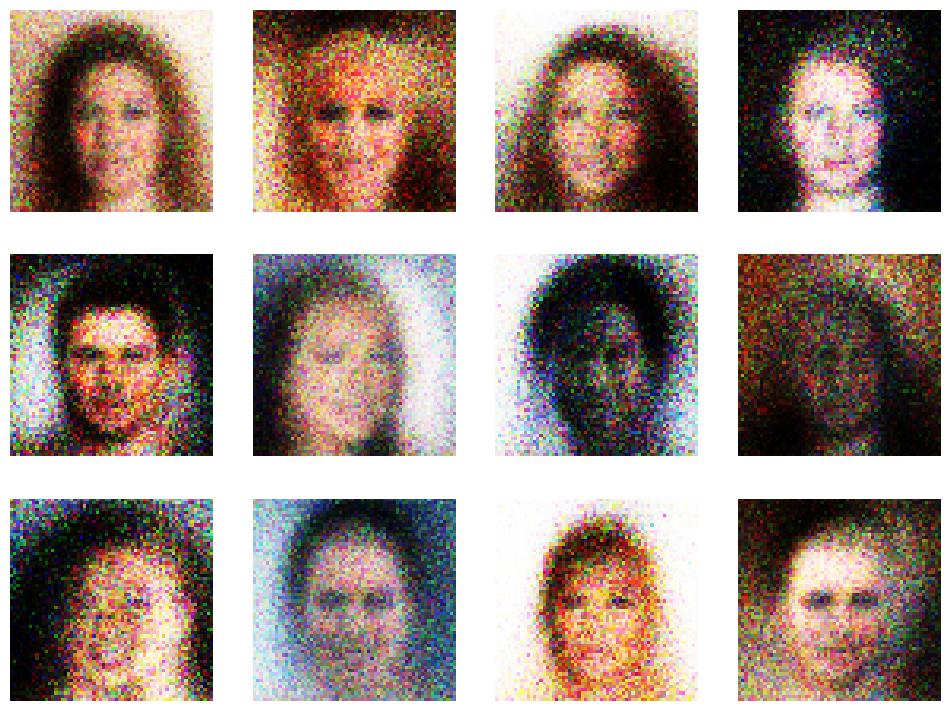

In [62]:
# Generate and visualize samples
n_row = 3
n_col = 4

# Sample noise and generate images
z = Variable(Tensor(np.random.normal(0, 1, (n_row * n_col, latent_dim))))
gen_imgs = generator(z)

# Rescale images to 0-1 range
gen_imgs = 0.5 * (gen_imgs + 1.0)

# Plot images
fig, axes = plt.subplots(n_row, n_col, figsize=(12, 9))
for i in range(n_row):
    for j in range(n_col):
        axes[i,j].imshow(gen_imgs[i*n_col + j].detach().cpu().permute(1, 2, 0))
        axes[i,j].axis('off')
plt.show()


# **Objective**

The objective of this lab was to implement and train a Generative Adversarial Network (GAN) using PyTorch to generate synthetic images similar to those in the MNIST dataset and later apply the GAN architecture to the CelebA dataset.


# **Implementation Overview**

## **Architecture**
The GAN consists of two main components:

1. **Generator**:  
   - A fully connected neural network that takes a latent vector as input and generates synthetic images.

2. **Discriminator**:  
   - Another fully connected neural network that evaluates whether the input images are real (from the dataset) or fake (generated by the Generator).

## **Training Process**
The training process involves alternating updates between the Generator and the Discriminator:

- **Discriminator**: Trained to maximize its ability to distinguish between real and fake images.
- **Generator**: Trained to minimize the Discriminator's ability to classify its generated images as fake.

## **Loss Function**
- Binary Cross-Entropy (BCE) loss is used for both the Generator and Discriminator, as it is suitable for binary classification tasks.

## **Data Loading**
- **MNIST Dataset**: Loaded from a CSV file.
- **CelebA Dataset**: Loaded using PyTorch's `ImageFolder` class with appropriate transformations.


# **Results**

## **MNIST Dataset**
- The Generator successfully produced images resembling handwritten digits after training for 50 epochs.
- The generated images were visualized in batches, showing a variety of digits.

## **CelebA Dataset**
- The GAN was adapted to generate 64x64 RGB images of celebrity faces.
- Training was limited to 3 epochs due to computational constraints.
- The generated images were visualized, demonstrating the Generator's ability to create diverse facial features.


# **Analysis**

### **Quality of Generated Images**
- The quality of images generated by the GAN improved over epochs, indicating that the model learned to capture the underlying distribution of the training data.

### **Training Dynamics**
- The loss values for both the Generator and Discriminator fluctuated during training, which is expected in GANs due to their adversarial nature.  
- The Discriminator's loss typically decreased as it became better at distinguishing real from fake images, while the Generator's loss decreased as it learned to produce more realistic images.

### **Challenges**
- Training GANs can be unstable, and careful tuning of hyperparameters (e.g., learning rates and batch sizes) is crucial for achieving good results.  
- Techniques like Batch Normalization and different activation functions (e.g., LeakyReLU) helped stabilize training.


# **Conclusion**

The lab successfully demonstrated the implementation and training of GANs using PyTorch. The results showed that GANs can effectively generate synthetic images that resemble real data distributions.  
